# Assignment 2 - Sarsa

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Importing packages

In [1]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
rnd = np.random.default_rng(112233)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Frozen lake 

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='ansi')

matrix = np.zeros((env.observation_space.n, env.action_space.n))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Sarsa class

In [3]:
class sarsa():
    def __init__(self, decision_matrix, alpha=.85, gamma=.95, temperature=.05, expected=False):
        self.a = alpha
        self.g = gamma
        self.q = decision_matrix
        self.temp = temperature
        self.expected = expected

        return

    def update(self, reward, state, action, next_state, next_action=None):  # next action can be none in the expected

        if self.expected: 
            self.q[state, action] = self.q[state, action] + self.a * (
                    reward + self.g * np.sum(self.q[next_state, :] * self.boltzmann(next_state))
                    - self.q[state, action])
        else:
            self.q[state, action] = self.q[state, action] + self.a * (
                    reward + self.g * self.q[next_state, next_action] - self.q[state, action])

        return None

    def choose(self, env, state, greedy):

        if np.max(self.q[state]) == 0:
            # random sampling
            chosen = rnd.choice(list(range(env.action_space.n)))
        elif greedy or (self.temp <= 0):  # temp 0 means greedy, and cannot go to boltzmann to avoid division by 0
            # greedy choice
            chosen = np.argmax(self.q[state])
        else:
            # boltzmann probability
            prob = self.boltzmann(state)
            chosen = rnd.choice(list(range(env.action_space.n)), p=prob)

        return chosen

    def boltzmann(self, state):
        actions = np.divide(self.q[state], self.temp)
        upper = np.exp(actions)
        lower = np.sum(upper)
        return upper / lower

        

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building the training process

In [4]:
# defining one episode
def episode(model, env, greedy=0):
    env.reset()
    state = 0  # initializing the state
    ended = False
    reward = 0

    if not model.expected:
        # Choose A from S
        action = model.choose(env, state, greedy)

    while not ended:

        if model.expected:
            # Choose A from S
            action = model.choose(env, state, greedy)

        # take A from S and get S'
        new_state, reward, ended, time_limit, prob = env.step(action)

        if model.expected:
            if greedy: # testing episode wont update
                # updating
                model.update(reward, state, action, new_state, None)
        else:
            # choose A' from S'
            new_action = model.choose(env, new_state, greedy)
            
            if greedy: # testing episode wont update
                # updating
                model.update(reward, state, action, new_state, new_action)
            # A <- A'
            action = new_action

        # S <- S'
        state = new_state

        if time_limit:
            break

    return {'reward':reward, 'mode':greedy}

In [5]:
# defining process for each of the segments
def segment(model, env, training,verbose):
    results = {}

    for i, mode in enumerate(training):
        if verbose:
            print(f"-{i + 1}", end='')
        episode_result = episode(model, env, mode)
        results[i] = episode_result

    return results

In [6]:
# defining process for each of the runs
def run(model, env, segments_n=500, training=np.append(np.zeros(10), [1]),verbose=True):
    run_results = {}
    for i, mode in enumerate(range(segments_n)):
        if verbose:
            print(f"\n{i + 1}th Segment:", end='')
            
        run_results[i] = segment(model, env, training,verbose)

    return run_results

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Running the model

In [7]:
# configurations

temperatures = [.01,.1,.5]
learning_rates = [.15,.5,.85]
expected = ['classic','expected']
n_runs = 10
rolling_window = 10

training_size = 10
testing_size = 1


In [8]:
# Declaring the model

models = []
general_results = {}
for type_ in expected:
    general_results[type_] = {}
    for alpha in learning_rates:
        general_results[type_][alpha] = {}
        for temp in temperatures:
            general_results[type_][alpha][temp] = {}
            
            bool_type = True if type_ == 'expected' else False
            #creating model to use as standard for each run config
            models.append(sarsa(matrix.copy(),alpha=alpha,temperature=temp, expected=bool_type))

In [9]:
# Runing the training

for model in models:
    model_type = 'expected' if model.expected else 'classic'
    print(f'Training on |temperature: {str(model.temp)}\t| alpha: {str(model.a)} \t| {model_type} Sarsa')
    
    for i in range(n_runs):
        # creating model copies for each run 
        n_model =sarsa(matrix.copy(),alpha=model.a,temperature=model.temp, expected=model.expected)
        general_results[model_type][model.a][model.temp][i] = run(n_model,env,training=np.append(np.zeros(training_size), [testing_size]),verbose=False)
        
    

Training on |temperature: 0.01	| alpha: 0.15 	| classic Sarsa
Training on |temperature: 0.1	| alpha: 0.15 	| classic Sarsa
Training on |temperature: 0.5	| alpha: 0.15 	| classic Sarsa
Training on |temperature: 0.01	| alpha: 0.5 	| classic Sarsa
Training on |temperature: 0.1	| alpha: 0.5 	| classic Sarsa
Training on |temperature: 0.5	| alpha: 0.5 	| classic Sarsa
Training on |temperature: 0.01	| alpha: 0.85 	| classic Sarsa
Training on |temperature: 0.1	| alpha: 0.85 	| classic Sarsa
Training on |temperature: 0.5	| alpha: 0.85 	| classic Sarsa
Training on |temperature: 0.01	| alpha: 0.15 	| expected Sarsa
Training on |temperature: 0.1	| alpha: 0.15 	| expected Sarsa
Training on |temperature: 0.5	| alpha: 0.15 	| expected Sarsa
Training on |temperature: 0.01	| alpha: 0.5 	| expected Sarsa
Training on |temperature: 0.1	| alpha: 0.5 	| expected Sarsa
Training on |temperature: 0.5	| alpha: 0.5 	| expected Sarsa
Training on |temperature: 0.01	| alpha: 0.85 	| expected Sarsa
Training on |temp

In [10]:
df = pd.DataFrame.from_dict({(a,b,c,d,e,f): general_results[a][b][c][d][e][f]
                                           for a in general_results.keys() 
                                           for b in general_results[a].keys()
                                           for c in general_results[a][b].keys()
                                           for d in general_results[a][b][c].keys()
                                           for e in general_results[a][b][c][d].keys()
                                           for f in general_results[a][b][c][d][e].keys()},
                                           orient='index')

In [11]:
df = df.reset_index()
df = df.rename(columns={'level_0':'sarsa','level_1':'alpha','level_2':'temperature','level_3':'run','level_4':'segment','level_5':'episode'})
df.head(25)

,sarsa,alpha,temperature,run,segment,episode,reward,mode
0,classic,0.15,0.01,0,0,0,0.0,0.0
1,classic,0.15,0.01,0,0,1,0.0,0.0
2,classic,0.15,0.01,0,0,2,0.0,0.0
3,classic,0.15,0.01,0,0,3,0.0,0.0
4,classic,0.15,0.01,0,0,4,0.0,0.0
5,classic,0.15,0.01,0,0,5,0.0,0.0
6,classic,0.15,0.01,0,0,6,0.0,0.0
7,classic,0.15,0.01,0,0,7,0.0,0.0
8,classic,0.15,0.01,0,0,8,0.0,0.0
9,classic,0.15,0.01,0,0,9,0.0,0.0


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Tabular RL
Pick 3 settings of the temperature parameter used in the exploration and 3 settings of the learning rate. You need to plot:

#### First plot

One u-shaped graph that shows the effect of the parameters on the final training performance,
expressed as the return of the agent (averaged over the last 10 training episodes and the 10
runs); note that this will typically end up as an upside-down u.

In [12]:
df_training = df[df['mode'] == 0] # getting training

results = {}

for model in df_training['sarsa'].unique():
    df_ = df_training[df_training['sarsa'] == model].copy()
    df_['seg-ep'] = (df_['segment'] * training_size) + df_['episode']
    df_ = df_[['alpha','temperature','reward','seg-ep']]
    
    for i,group in df_.groupby(['alpha','temperature']): # each config result
        a = list(group['alpha'])[0]
        t = list(group['temperature'])[0]
        
        if a not in results.keys():
            results[a] = {}
            
        if t not in results[a].keys():
            results[a][t] = {'classic':{},'expected':{}}
            
        
        results[a][t][model] = group.groupby('seg-ep').mean().rolling(rolling_window).mean().dropna()['reward']

alphas = list(results.keys())
temperatures = list(results[alphas[0]].keys())

In [13]:
def rms(arr):
    return np.sqrt(np.mean((1-np.array(arr))**2))

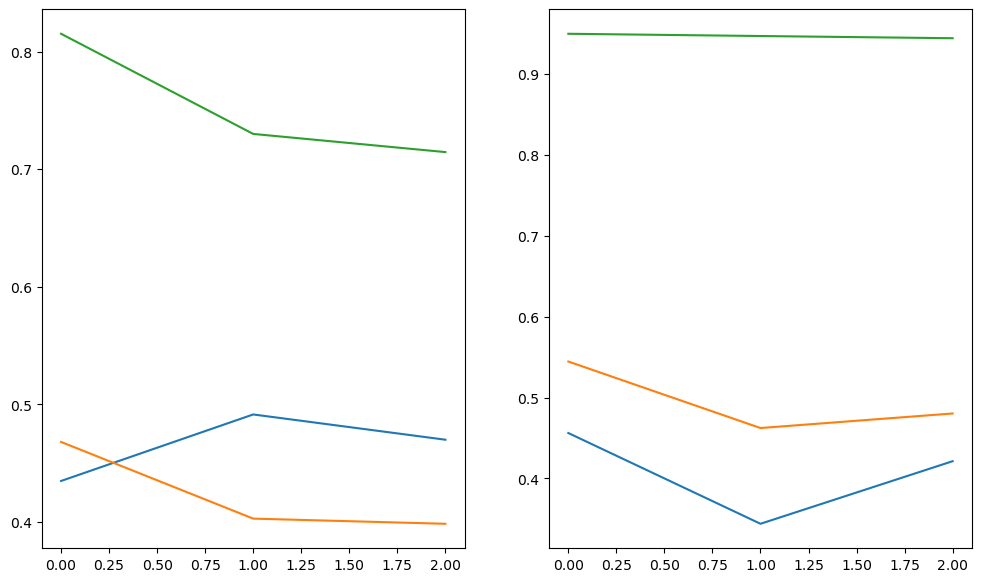

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,7))

for m,model in enumerate(expected):
    for j, temperature in enumerate(temperatures):
        line_values = []
        for i,alpha in enumerate(alphas):
            line_values.append(rms(results[alpha][temperature][model]))
        
        ax[m].plot(line_values)

#### Second plot

One u-shaped graph that shows the effect of the parameters on the final testing performance,
expressed as the return of the agent (during the final testing episode, averaged over the 10
runs)

In [15]:
df_testing = df[df['mode'] == 0] # getting test

results_test = {}

for model in df_testing['sarsa'].unique():
    df_ = df_training[df_training['sarsa'] == model].copy()
    df_['seg-ep'] = (df_['segment'] * testing_size) + df_['episode']
    df_ = df_[['alpha','temperature','reward','seg-ep']]
    
    for i,group in df_.groupby(['alpha','temperature']): # each config result
        a = list(group['alpha'])[0]
        t = list(group['temperature'])[0]
        
        if a not in results_test.keys():
            results_test[a] = {}
            
        if t not in results_test[a].keys():
            results_test[a][t] = {'classic':{},'expected':{}}
            
        
        results_test[a][t][model] = group.groupby('seg-ep').mean().rolling(rolling_window).mean().dropna()['reward']

alphas = list(results_test.keys())
temperatures = list(results_test[alphas[0]].keys())

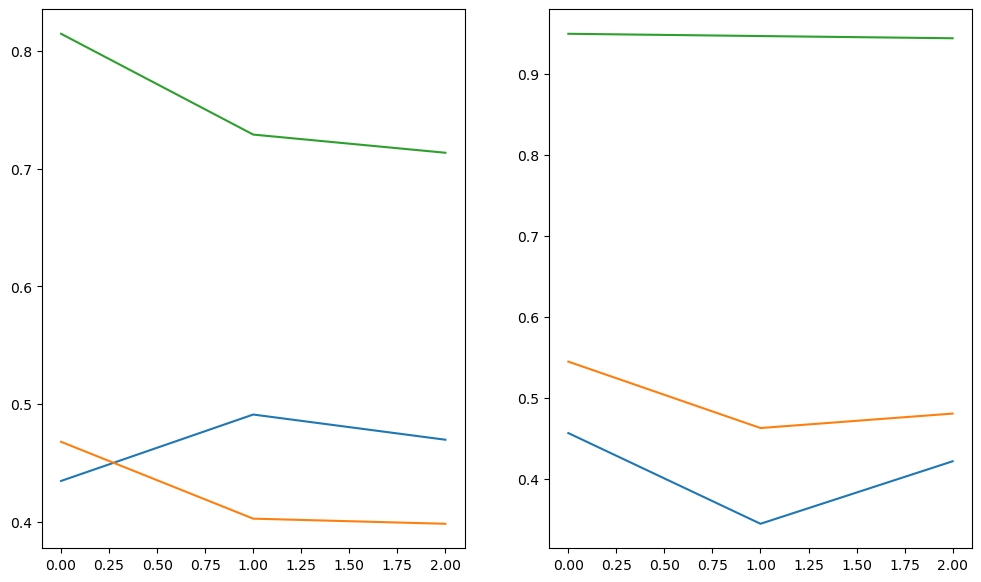

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,7))

for m,model in enumerate(results_test[alpha][temperature].keys()):
    for j, temperature in enumerate(temperatures):
        line_values = []
        for i,alpha in enumerate(alphas):
            line_values.append(rms(results_test[alpha][temperature][model]))
        
        ax[m].plot(line_values)

#### Third plot

Learning curves (mean and standard deviation computed based on the 10 runs) for what you
pick as the best parameter setting for each algorithm

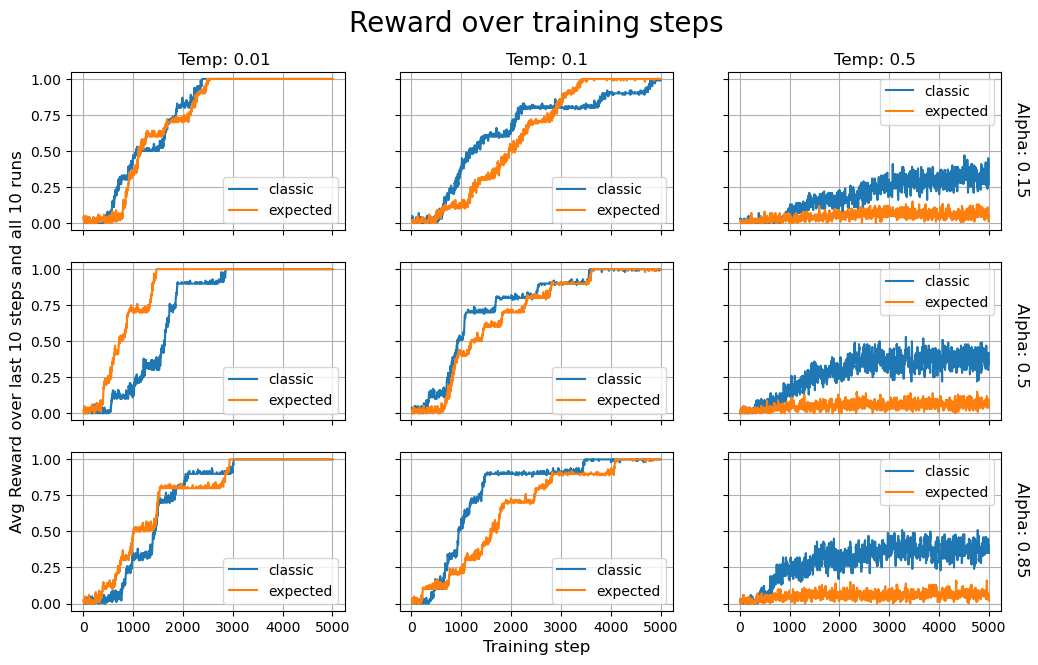

In [17]:
fig, ax = plt.subplots(len(alphas),len(temperatures), sharey='row', sharex='col',figsize=(12,7))

ax[0][1].set_title("Reward over training steps", y=1.2,fontsize=20)

for i,alpha in enumerate(alphas):
    
        
    for j, temperature in enumerate(temperatures):
        if i == 0:
            text = ax[i][j].text(1900,1.1,f"Temp: {temperature}", size=12)
            
        if j == 0 and i == 1:
            ax[i][j].set_ylabel(f'Avg Reward over last {rolling_window} steps and all {n_runs} runs',fontsize=12)
            
        if j == 2:
            text = ax[i][j].text(5500,.2,f"Alpha: {alpha}", size=12, rotation=270)
            
        
        if j == 1 and i == 2:
            ax[i][j].set_xlabel(f'Training step',fontsize=12)
            
        for model in results[alpha][temperature].keys():
            ax[i][j].plot(results[alpha][temperature][model],label=model)
            ax[i][j].legend()
            ax[i][j].grid(visible=True)
            
            
plt.show()